In [1]:
from gensim import models

from IPython.display import display, HTML

In [2]:
m = models.word2vec.Word2Vec.load("models/word2vec/all_pages.txt")

In [3]:
def print_questions(answers):
    html = "<table>"

    html += """
    <tr>
      <td></td>
      <th>philosophy</th>
      <th>continental philosophy</th>
      <th>analytic philosophy</th>
    </tr>
    """
    
    for question, control, analytic, continental in answers:
        html += "<tr><td style=\"width: 100px; text-align: center; \"><h3>%s</h3></td>" % question
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in control ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in analytic ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in continental ])
        html += "</ul></td>"
        html += "</tr>"
    
    html += "</table>"

    display(HTML(html))

def q(positive, negative, model):
  try:
    result = model.most_similar(positive=positive, negative=negative)
  except:
    result = []
  
  return result

questions = [ "philosophy", "science", "religion", "knowledge", "wisdom", "love" ]

print_questions(map(lambda question: (question, q(["philosophy", question], [], m),
                                      q(["continental_philosophy", question], ["analytic_philosophy"], m),
                                      q(["analytic_philosophy", question], ["continental_philosophy"], m)),questions))

,philosophy,continental philosophy,analytic philosophy
philosophy,psychology philosophy_science metaphysics mathematics ethics moral_philosophy philosophy_religion theology philosophical political_philosophy,philosophy_religion philosophy_science psychology ethics political_philosophy aesthetics western_philosophy theology contemporary_philosophy phenomenology,mathematics metaphysics psychology logic moral_philosophy philosophy_science theology ethics thesis natural_sciences
science,psychology philosophy_science ethics mathematics medicine moral_philosophy physics philosophy_religion metaphysics sciences,sciences anthropology technology arts social_sciences philosophy_science psychology ethics geography humanities,psychology natural_sciences mathematics physics medicine biology philosophy_science ethics logic knowledge
religion,theology ethics political_philosophy philosophy_religion judaism metaphysics mysticism enlightenment hegel's_philosophy philosophy_science,judaism christian christianity spirituality religions culture jewish religious humanism theology,theology christianity faith judaism christian atheism orthodoxy doctrine dogma morals
knowledge,metaphysics psychology ethics logic natural_sciences mathematics natural_science understanding scepticism philosophy's,understanding learning meditation human_nature scepticism dimension creativity imagination consciousness christian_faith,understanding distinction intuition perception reasoning scepticism rational divinity essence value
wisdom,knowledge philosophy's spirituality ethics understanding scepticism metaphysics theology meditation morals,sacred mysteries imagination spirituality spiritual magic quest spirit mystery yahweh,divine revelation immortality soul true flesh redemption salvation beauty spirit
love,passion meditation sex nature encounter wisdom beauty immortality spirit redemption,passion mystery beauty dark heart joy heaven shadows adventure adventures,beauty passion joy heart man's grace strange my beautiful soul


In [4]:
import numpy as np

In [5]:
A_question = np.array([ m[question] for question in questions ])

In [6]:
A_philosophy = reduce(lambda a,b: a+b, [ q(["philosophy", m[question]], [], m) for question in questions ])
A_philosophy = np.array([ m[w] for w,s in A_philosophy ])

In [7]:
A_continental = reduce(lambda a,b: a+b, [ q(["continental_philosophy", m[question]], ["analytic_philosophy"], m) for question in questions ])
A_continental = np.array([ m[w] for w,s in A_continental ])

In [8]:
A_analytic = reduce(lambda a,b: a+b, [ q(["analytic_philosophy", m[question]], ["continental_philosophy"], m) for question in questions ])
A_analytic = np.array([ m[w] for w,s in A_analytic ])

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)

A = np.append(A_question, A_philosophy, axis=0)
A = np.append(A, A_continental, axis=0)
A = np.append(A, A_analytic, axis=0)

pca = pca.fit(A)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

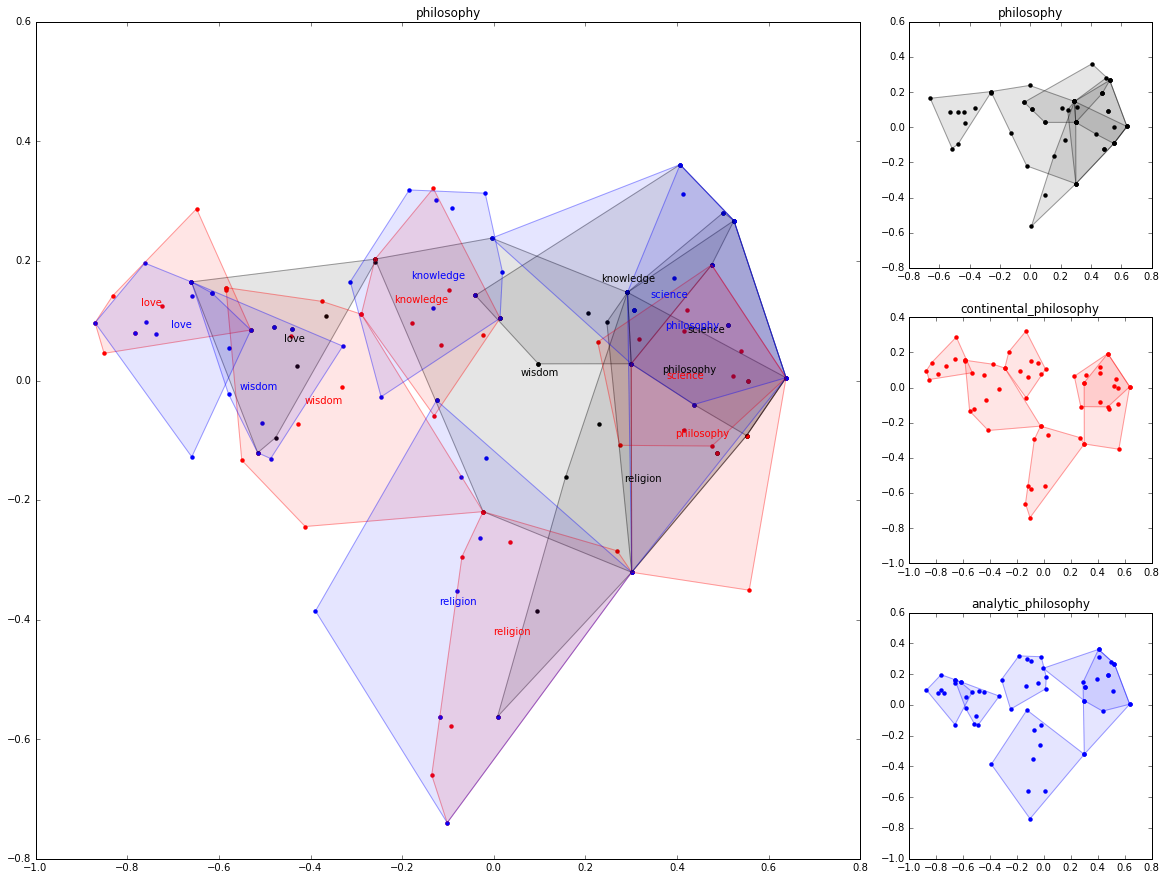

In [17]:
fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((3,4), (0, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((3,4), (0, 3))
ax3 = plt.subplot2grid((3,4), (1, 3))
ax4 = plt.subplot2grid((3,4), (2, 3))

s1 = [["philosophy"], [], "black" ]
s2 = [["continental_philosophy"], ["analytic_philosophy"], "red" ]
s3 = [["analytic_philosophy"], ["continental_philosophy"], "blue" ]

def plot_words(ax, s, label=False):
  
  ax.set_title(s[0][0][0])
  
  s = [ (p+[question],n,c) for (p,n,c) in s for question in questions  ]

  for p, n, c in s:
    Z = pca.transform(np.array([ m[w] for w,s in q(p,n,m) ]))

    hull = ConvexHull(Z)

    for simplex in hull.simplices:
      ax.fill(Z[simplex, 0], Z[simplex, 1], '-', color=c, alpha=0.3)

    simplex_x = []
    simplex_y = []

    for simplex in hull.vertices:
      simplex_x.append(Z[simplex, 0])
      simplex_y.append(Z[simplex, 1])

    if label:
      ax.text(np.mean(simplex_x), np.mean(simplex_y), p[1], color=c, horizontalalignment='center', verticalalignment='center',)
      
    simplex_x.append(Z[hull.vertices[0], 0])
    simplex_y.append(Z[hull.vertices[0], 1])

    ax.fill(simplex_x, simplex_y, '-', color=c, alpha=0.1)

    Z_ = zip(*Z)

    ax.scatter(Z_[0], Z_[1], lw=0, color=c)

plot_words(ax1, [s1]+[s2]+[s3], label=True)
plot_words(ax2, [s1])
plot_words(ax3, [s2])
plot_words(ax4, [s3])

plt.show()